In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .master("yarn") \
        .appName("ddareungi") \
        .getOrCreate()
sc = spark.sparkContext

<대여소정보>
 - 지역별(구 단위) 따릉이 대여소의 총 수/가장 많은 곳/가장 적은 곳는?
 - 지역별(구 단위) 따릉이 거치대의 총 수/가장 많은 곳/가장 적은 곳는?


<위치별 대여수 정보>
 - 총 데이터 누적 기준 가장 많은 따릉이가 대여/반납된 대여소는?
 - 총 데이터 누적 기준 가장 많은 따릉이가 대여/반납된 구는?
 - 총 데이터 누적 기준 따릉이 대여와 반납의 차이가 가장 큰 대여소/구는?


<일자별/월별 대여수 정보>
 - 2018년 전체 대여소 중 7/8/9/10월의 평균/일최대 따릉이 대여수는?
 - 지역별 월별 따릉이 대여/반납 누적 수는?


<테이블조인>
 - 거치대 수 대비 따릉이 대여/반납 비율이 가장 높은 대여소/구는?
 - 따릉이 대여가 100건 이상 이루어진 경우가 있는 대여소 중 가장 남쪽에 있는 대여소는?

In [4]:
# Load location data
df_loc = spark.read.option("header", "true") \
                    .option("nullValue", "?") \
                    .option("inferSchema", "true") \
                    .csv('bikeshare_loc.csv')

df_loc.show()

+---+------+-----+--------------------+--------------------+----+---------+----------+
| 구명| 대여소ID|대여소번호|                대여소명|              대여소 주소|거치대수|       위도|        경도|
+---+------+-----+--------------------+--------------------+----+---------+----------+
|강남구|ST-777| 2301|          현대고등학교 건너편|서울특별시 강남구 압구정로 13...|  10|37.524071| 127.02179|
|강남구|ST-787| 2302|교보타워 버스정류장(신논현역 3...|서울특별시 강남구 봉은사로 지하...|  10|37.505581|127.024277|
|강남구|ST-788| 2303|            논현역 7번출구|서울특별시 강남구 학동로 지하 ...|  15|37.511517|127.021477|
|강남구|ST-789| 2304|   신영 ROYAL PALACE 앞|서울특별시 강남구 언주로 626...|  10|37.512527|127.035835|
|강남구|ST-790| 2305|        MCM 본사 직영점 앞|서울특별시 강남구 언주로 734...|  10|37.520641|127.034508|
|강남구|ST-791| 2306|        압구정역 2번 출구 옆|서울특별시 강남구 압구정로 지하...|  30|37.527122|127.028717|
|강남구|ST-792| 2307|       압구정 한양 3차 아파트|서울특별시 강남구 압구정로 32...|  10|37.528614|127.038559|
|강남구|ST-793| 2308|            압구정파출소 앞|서울특별시 강남구 압구정로 31...|  14|37.529301|127.035599|
|강남구|ST-783| 2309|        청담역(우리들병원 앞)|서울특별

In [5]:
df_loc.filter(df_loc['대여소번호'] == 2319).show()

+---+------+-----+--------------------+--------------------+----+---------+---------+
| 구명| 대여소ID|대여소번호|                대여소명|              대여소 주소|거치대수|       위도|       경도|
+---+------+-----+--------------------+--------------------+----+---------+---------+
|강남구|ST-802| 2319|포스코4거리 서측(수협 삼성동 지점)|서울특별시 강남구 테헤란로 43...|  10|37.506607|127.05468|
+---+------+-----+--------------------+--------------------+----+---------+---------+



In [6]:
import pyspark.sql.functions as sf

In [26]:
df_usage = spark.read.option("header", "true") \
                    .option("nullValue", "?") \
                    .option("inferSchema", "true") \
                    .csv('bikeshare_seoul.csv')

df_usage.show()

+-----+--------------------+-------------------+----+----+
|대여소위치|                대여소명|               기준일자|대여건수|반납건수|
+-----+--------------------+-------------------+----+----+
|  동작구|2067. LG전자 베스트샾 대...|2018-11-30 00:00:00|  16|  11|
|  양천구|  726. 목동3단지 시내버스정류장|2018-11-30 00:00:00|  30|  27|
|  양천구|     725. 양강중학교앞 교차로|2018-11-30 00:00:00|  14|   5|
|  양천구|724. 계남공원 입구 주출입구 좌측|2018-11-30 00:00:00|   3|   0|
|  양천구|         723. SBS방송국|2018-11-30 00:00:00|  38|  44|
|  양천구|  722. LG전자베스트샵 신정점 |2018-11-30 00:00:00|  29|  28|
|  마포구|       426. 서울신용보증재단|2018-11-30 00:00:00|  11|  22|
|  마포구|      425. DMC첨단산업센터|2018-11-30 00:00:00|  14|  11|
|  마포구|424. 롯데하이마트 (상암월드...|2018-11-30 00:00:00|   2|   3|
|  광진구|  502. 뚝섬유원지역 1번출구 앞|2018-11-30 00:00:00|  63|  75|
|  광진구|     3505. 신양초교앞 교차로|2018-11-30 00:00:00|  19|  20|
|  광진구|          3504. 원일교회|2018-11-30 00:00:00|  38|  33|
|  광진구|      3502. 중곡역 1번출구|2018-11-30 00:00:00|   8|  15|
|  광진구|        3501. 광진구청 앞|2018-11-30 00:00:00|  46|  3

In [27]:
usage100 = df_usage.filter(df_usage['대여건수'] >= 100) .select('대여건수', '반납건수',  sf.split('대여소명', '[.]')[0].alias('대여소번호'))

In [28]:
usage100.show()

+----+----+-----+
|대여건수|반납건수|대여소번호|
+----+----+-----+
| 119| 132| 1210|
| 116| 139| 1308|
| 144| 202|  113|
| 104| 104|  590|
| 129| 140| 1308|
| 122| 194|  113|
| 120| 121|  590|
| 116| 115| 1308|
| 130| 205|  113|
| 131| 130|  590|
| 101| 102| 1210|
| 104| 131| 1308|
| 140| 201|  113|
| 102| 115|  592|
| 118| 116|  590|
| 130| 129| 1210|
| 141| 158| 1308|
| 107| 105|  540|
| 155| 209|  113|
| 100| 101| 1210|
+----+----+-----+
only showing top 20 rows



In [29]:
df_joined = usage100.join(df_loc.select('대여소번호','구명','대여소명','위도'), on='대여소번호', how='inner')
df_joined.show()

+-----+----+----+---+-----------------+---------+
|대여소번호|대여건수|반납건수| 구명|             대여소명|       위도|
+-----+----+----+---+-----------------+---------+
| 1210| 119| 132|송파구|롯데월드타워(잠실역2번출구 쪽)|37.513126|
| 1308| 116| 139|성북구|    안암로터리 버스정류장 앞|37.582592|
|  113| 144| 202|마포구|     홍대입구역 2번출구 앞|37.557499|
|  590| 104| 104|광진구|    건국대학교 (입학정보관)| 37.53989|
| 1308| 129| 140|성북구|    안암로터리 버스정류장 앞|37.582592|
|  113| 122| 194|마포구|     홍대입구역 2번출구 앞|37.557499|
|  590| 120| 121|광진구|    건국대학교 (입학정보관)| 37.53989|
| 1308| 116| 115|성북구|    안암로터리 버스정류장 앞|37.582592|
|  113| 130| 205|마포구|     홍대입구역 2번출구 앞|37.557499|
|  590| 131| 130|광진구|    건국대학교 (입학정보관)| 37.53989|
| 1210| 101| 102|송파구|롯데월드타워(잠실역2번출구 쪽)|37.513126|
| 1308| 104| 131|성북구|    안암로터리 버스정류장 앞|37.582592|
|  113| 140| 201|마포구|     홍대입구역 2번출구 앞|37.557499|
|  592| 102| 115|광진구|       건국대학교 학생회관|37.541912|
|  590| 118| 116|광진구|    건국대학교 (입학정보관)| 37.53989|
| 1210| 130| 129|송파구|롯데월드타워(잠실역2번출구 쪽)|37.513126|
| 1308| 141| 158|성북구|    안암로터리 버스정류장 앞|37.582592|


In [30]:
from pyspark.sql.functions import col
df_joined.sort(col("위도").asc()).show()

+-----+----+----+---+--------------------+---------+
|대여소번호|대여건수|반납건수| 구명|                대여소명|       위도|
+-----+----+----+---+--------------------+---------+
| 1820| 154| 253|금천구|     신한은행 시흥대로금융센터지점| 37.44334|
| 1816| 181| 150|금천구|            금천폭포공원 앞|37.446861|
| 2203| 190| 135|서초구|         청계산입구역 2번출구|37.447659|
| 2202|1054|1082|서초구|         청계산입구역 1번출구|37.448936|
| 2270| 238| 252|서초구|          서초포레스타 7단지|37.448967|
| 1821| 243| 314|금천구|홈플러스 시흥점 맞은편 다비치안경 앞|37.451458|
| 1822| 405| 456|금천구|         서울 시흥동우체국 앞|37.452991|
| 2201| 155| 174|서초구|           본마을 정류소 앞|37.453281|
| 2205| 587| 548|서초구|       내곡3단지 어린이공원 앞|37.453751|
| 2206| 913| 914|서초구|            언남초등학교 앞|37.454399|
| 2207| 138|  96|서초구|          내곡파출소 뒤 정자|37.454407|
| 1825| 195| 204|금천구|       한신아파트 앞 육교 아래|  37.4547|
| 2250| 548| 505|서초구|           서초유치원 맞은편|37.455799|
| 1827|1201|1242|금천구|    독산보도육교 앞 자전거 보관소|37.455849|
| 1827| 123| 114|금천구|    독산보도육교 앞 자전거 보관소|37.455849|
| 2249| 296| 289|서초구|          우솔초등학교 맞은편|37.4

In [31]:
# Load usage data
df_usage = spark.read.option("header", "true") \
                    .option("nullValue", "?") \
                    .option("inferSchema", "true") \
                    .csv('bikeshare_seoul.csv')

df_usage.show()

+-----+--------------------+-------------------+----+----+
|대여소위치|                대여소명|               기준일자|대여건수|반납건수|
+-----+--------------------+-------------------+----+----+
|  동작구|2067. LG전자 베스트샾 대...|2018-11-30 00:00:00|  16|  11|
|  양천구|  726. 목동3단지 시내버스정류장|2018-11-30 00:00:00|  30|  27|
|  양천구|     725. 양강중학교앞 교차로|2018-11-30 00:00:00|  14|   5|
|  양천구|724. 계남공원 입구 주출입구 좌측|2018-11-30 00:00:00|   3|   0|
|  양천구|         723. SBS방송국|2018-11-30 00:00:00|  38|  44|
|  양천구|  722. LG전자베스트샵 신정점 |2018-11-30 00:00:00|  29|  28|
|  마포구|       426. 서울신용보증재단|2018-11-30 00:00:00|  11|  22|
|  마포구|      425. DMC첨단산업센터|2018-11-30 00:00:00|  14|  11|
|  마포구|424. 롯데하이마트 (상암월드...|2018-11-30 00:00:00|   2|   3|
|  광진구|  502. 뚝섬유원지역 1번출구 앞|2018-11-30 00:00:00|  63|  75|
|  광진구|     3505. 신양초교앞 교차로|2018-11-30 00:00:00|  19|  20|
|  광진구|          3504. 원일교회|2018-11-30 00:00:00|  38|  33|
|  광진구|      3502. 중곡역 1번출구|2018-11-30 00:00:00|   8|  15|
|  광진구|        3501. 광진구청 앞|2018-11-30 00:00:00|  46|  3

In [32]:
import pyspark.sql.functions as sf
U2318_may = df_usage.where(df_usage['기준일자'].between('2018-05-01', '2018-05-31')).select('기준일자', '대여건수', '반납건수',  sf.split('대여소명', '[.]')[0].alias('대여소번호')).filter(col('대여소번호') == 2318)
U2318_may.show()

+-------------------+----+----+-----+
|               기준일자|대여건수|반납건수|대여소번호|
+-------------------+----+----+-----+
|2018-05-30 00:00:00|  18|  16| 2318|
|2018-05-29 00:00:00|   8|   9| 2318|
|2018-05-28 00:00:00|  13|  14| 2318|
|2018-05-27 00:00:00|   7|   9| 2318|
|2018-05-26 00:00:00|  16|  15| 2318|
|2018-05-25 00:00:00|  27|  14| 2318|
|2018-05-24 00:00:00|  26|  20| 2318|
|2018-05-23 00:00:00|  24|  18| 2318|
|2018-05-22 00:00:00|   6|  12| 2318|
|2018-05-21 00:00:00|  21|  16| 2318|
|2018-05-20 00:00:00|  21|  22| 2318|
|2018-05-19 00:00:00|  13|  14| 2318|
|2018-05-18 00:00:00|  11|   4| 2318|
|2018-05-17 00:00:00|   1|   3| 2318|
|2018-05-16 00:00:00|   2|   2| 2318|
|2018-05-15 00:00:00|  21|  13| 2318|
|2018-05-14 00:00:00|  19|  10| 2318|
|2018-05-13 00:00:00|  23|  15| 2318|
|2018-05-11 00:00:00|  26|  20| 2318|
|2018-05-10 00:00:00|  16|   7| 2318|
+-------------------+----+----+-----+
only showing top 20 rows



In [33]:
U2318_may_pd = U2318_may.toPandas()

/usr/local/lib64/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


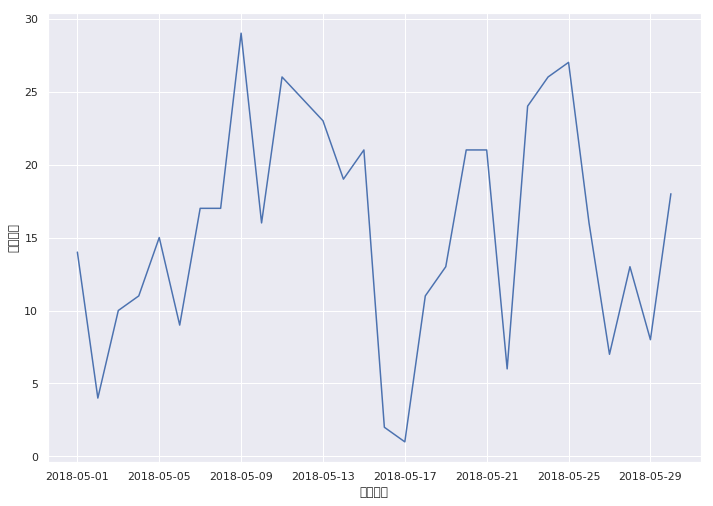

In [34]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x='기준일자', y='대여건수', data=U2318_may.toPandas())
plt.show()

___
## <대여소정보>


 - 지역별(구 단위) 따릉이 대여소의 총 수/가장 많은 곳/가장 적은 곳는?

In [35]:
df_loc.groupBy('구명').count().orderBy('count').show()

+----+-----+
|  구명|count|
+----+-----+
| 도봉구|   31|
| 용산구|   37|
| 강북구|   37|
|  중구|   38|
| 동작구|   41|
| 금천구|   42|
|동대문구|   49|
| 관악구|   51|
|서대문구|   51|
| 양천구|   51|
| 중랑구|   52|
| 구로구|   56|
| 성북구|   56|
| 강동구|   57|
| 광진구|   57|
| 은평구|   60|
| 성동구|   62|
| 종로구|   63|
| 노원구|   66|
| 마포구|   75|
+----+-----+
only showing top 20 rows



In [36]:
import seaborn as sns

In [37]:
df_loc.groupBy('구명').count().orderBy('count', ascending=False).show()

+----+-----+
|  구명|count|
+----+-----+
| 강남구|   95|
| 서초구|   87|
| 송파구|   86|
|영등포구|   84|
| 강서구|   76|
| 마포구|   75|
| 노원구|   66|
| 종로구|   63|
| 성동구|   62|
| 은평구|   60|
| 광진구|   57|
| 강동구|   57|
| 성북구|   56|
| 구로구|   56|
| 중랑구|   52|
| 관악구|   51|
|서대문구|   51|
| 양천구|   51|
|동대문구|   49|
| 금천구|   42|
+----+-----+
only showing top 20 rows



In [38]:
pd_loc_count = df_loc.groupBy('구명').count().orderBy('count', ascending=False)

In [39]:
import matplotlib.pylab as plt

In [40]:
result = df_loc.select('구명').toPandas()

In [41]:
import matplotlib as mpl
mpl.matplotlib_fname()

'/usr/local/lib64/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc'

In [42]:
import matplotlib.font_manager as fm
fonts = fm.findSystemFonts()
print(fonts)

['/usr/share/fonts/dejavu/DejaVuSansCondensed.ttf', '/usr/share/fonts/nhn-nanum/NanumGothic.ttf', '/usr/share/fonts/dejavu/DejaVuSansCondensed-Bold.ttf', '/usr/share/fonts/nhn-nanum/NanumGothicExtraBold.ttf', '/usr/share/fonts/dejavu/DejaVuSans.ttf', '/usr/share/fonts/dejavu/DejaVuSans-Oblique.ttf', '/usr/share/fonts/nhn-nanum/NanumGothicBold.ttf', '/usr/share/fonts/dejavu/DejaVuSansCondensed-BoldOblique.ttf', '/usr/share/fonts/dejavu/DejaVuSans-Bold.ttf', '/usr/share/fonts/dejavu/DejaVuSans-BoldOblique.ttf', '/usr/share/fonts/dejavu/DejaVuSans-ExtraLight.ttf', '/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf']


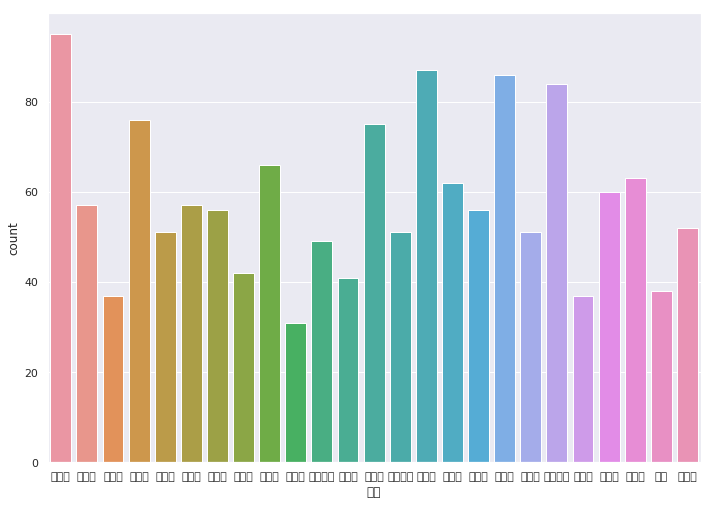

In [43]:
fontname = fm.FontProperties(fname='/usr/share/fonts/nhn-nanum/NanumGothic.ttf').get_name()
mpl.rc('font', family = fontname)
sns.countplot(x='구명', data=result)
plt.show()

In [44]:
df_loc.groupBy('구명').count().orderBy('count', ascending=True).take(1)

[Row(구명='도봉구', count=31)]

 - 지역별(구 단위) 따릉이 거치대의 총 수/가장 많은 곳/가장 적은 곳는?

In [45]:
df_loc.groupBy('구명').sum('거치대수').orderBy('sum(거치대수)', ascending=False).show()

+----+---------+
|  구명|sum(거치대수)|
+----+---------+
| 서초구|     1214|
|영등포구|     1191|
| 강남구|     1150|
| 송파구|     1130|
| 마포구|     1025|
| 강서구|      884|
| 노원구|      840|
| 성동구|      771|
| 강동구|      763|
| 광진구|      720|
| 종로구|      706|
| 성북구|      687|
| 은평구|      671|
| 구로구|      661|
|서대문구|      643|
|동대문구|      633|
| 관악구|      632|
| 양천구|      628|
| 중랑구|      616|
| 용산구|      523|
+----+---------+
only showing top 20 rows



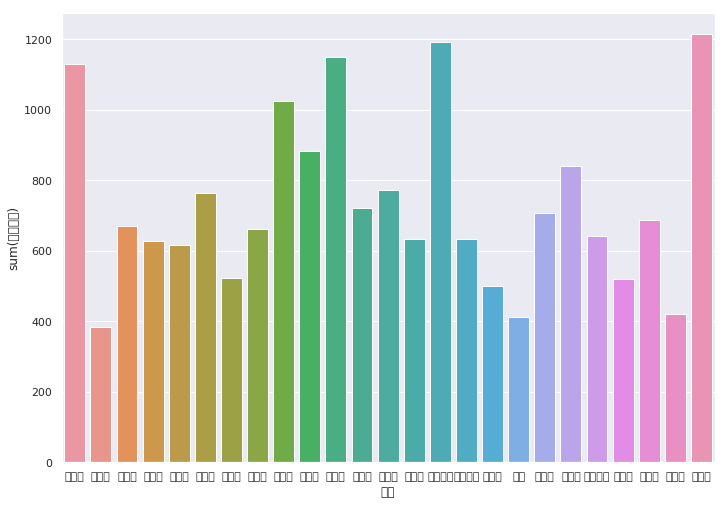

In [46]:
result = df_loc.groupBy('구명').sum('거치대수').toPandas()
sns.barplot(x="구명", y="sum(거치대수)", data=result)
plt.show()

In [47]:
df_loc.groupBy('구명').sum('거치대수').orderBy('sum(거치대수)', ascending=False).take(1)

[Row(구명='서초구', sum(거치대수)=1214)]

In [48]:
df_loc.groupBy('구명').sum('거치대수').orderBy('sum(거치대수)', ascending=True).take(1)

[Row(구명='도봉구', sum(거치대수)=383)]

In [49]:
# 이런식으로 이름도 따로 줄 수 있음, 아래부턴 이 방식으로 진행
import pyspark.sql.functions as sf
df_loc.groupBy('구명')\
    .agg(sf.sum("거치대수").alias('총거치대수'))\
    .orderBy('총거치대수', ascending=False)\
    .take(1)

[Row(구명='서초구', 총거치대수=1214)]

___
## <위치별 대여수 정보>

 - 총 데이터 누적 기준 가장 많은 따릉이가 대여/반납된 대여소는?

In [50]:
df_usage.groupBy('대여소명')\
    .agg(sf.sum("대여건수").alias('총대여건수'))\
    .orderBy('총대여건수', ascending=False)\
    .show()

+--------------------+------+
|                대여소명| 총대여건수|
+--------------------+------+
|   207. 여의나루역 1번출구 앞|159695|
|  502. 뚝섬유원지역 1번출구 앞|121702|
|   113. 홍대입구역 2번출구 앞|116752|
|     152. 마포구민체육센터 앞| 65325|
|     106. 합정역 7번출구 앞| 61311|
|1210. 롯데월드타워(잠실역2...| 58136|
|       358. 성대입구 사거리| 56064|
|         419. 홈플러스 앞| 55478|
|       2102. 봉림교 교통섬| 55299|
|        501. 광진구의회 앞| 54803|
|2219. 고속터미널역 8-1번...| 53845|
|     102. 망원역 1번출구 앞| 53573|
|         421. 마포구청 앞| 52964|
|    247. 당산역 10번출구 앞| 52780|
|   114. 홍대입구역 8번출구 앞| 51866|
|    211. 여의도역 4번출구 옆| 51856|
|   511. 서울숲역 4번 출구 옆| 50123|
|         311. 서울광장 옆| 49499|
|        907. CJ 드림시티| 49412|
|       409. 누리꿈스퀘어 옆| 48941|
+--------------------+------+
only showing top 20 rows



 - 총 데이터 누적 기준 가장 많은 따릉이가 대여/반납된 구는?

In [51]:
df_usage.groupBy('대여소위치')\
    .agg(sf.sum("대여건수").alias('총대여건수'))\
    .orderBy('총대여건수', ascending=False)\
    .show()

+-----+-------+
|대여소위치|  총대여건수|
+-----+-------+
|  마포구|2116691|
| 영등포구|1836859|
|  종로구|1309361|
|  성동구|1035122|
|  광진구|1017865|
|  송파구| 820438|
| 서대문구| 810534|
| 동대문구| 651099|
|   중구| 631085|
|  서초구| 568709|
|  강남구| 531907|
|  노원구| 492055|
|  은평구| 491372|
|  강서구| 474419|
|  관악구| 454347|
|  용산구| 408850|
|  구로구| 400180|
|  강동구| 388399|
|  성북구| 371708|
|  동작구| 361097|
+-----+-------+
only showing top 20 rows



 - 총 데이터 누적 기준 따릉이 대여와 반납의 차이가 가장 큰 대여소/구는?

In [61]:
df_usage.withColumn('대여차이', df_usage['대여건수']-df_usage['반납건수']).take(1)

[Row(대여소위치='동작구', 대여소명='2067. LG전자 베스트샾 대리점 앞', 기준일자=datetime.datetime(2018, 11, 30, 0, 0), 대여건수=16, 반납건수=11, 대여차이=5)]

In [52]:
df_usage.withColumn('대여차이', abs(df_usage['대여건수']-df_usage['반납건수']))\
    .groupBy('대여소위치')\
    .agg(sf.sum("대여차이").alias('총대여차이'))\
    .orderBy('총대여차이', ascending=False)\
    .take(1)

# 대여소위치만 대여소명 으로 바꾸면 됩니다

[Row(대여소위치='종로구', 총대여차이=69789)]

## <일자별/월별 대여수 정보>

 - 2018년 전체 대여소 중 7/8/9/10월의 평균/일최대 따릉이 대여수는?

In [53]:
# between은 경계 모두 포함
df_usage.where(df_usage['기준일자'].between('2018-07-01', '2018-07-31'))\
    .groupBy('기준일자')\
    .agg(sf.avg('대여건수').alias('평균대여건수'))\
    .orderBy('평균대여건수', ascending=False)\
    .show()

df_usage.where(df_usage['기준일자'].between('2018-07-01', '2018-07-31'))\
    .groupBy('기준일자')\
    .agg(sf.max('대여건수').alias('최대대여건수'))\
    .orderBy('최대대여건수', ascending=False)\
    .take(1)

# 문제 조건에 맞게 날짜만 수정

+-------------------+------------------+
|               기준일자|            평균대여건수|
+-------------------+------------------+
|2018-07-06 00:00:00| 39.23771790808241|
|2018-07-08 00:00:00|38.198412698412696|
|2018-07-07 00:00:00| 38.07692307692308|
|2018-07-04 00:00:00| 36.15810276679842|
|2018-07-13 00:00:00|35.579905063291136|
|2018-07-12 00:00:00|34.447867298578196|
|2018-07-17 00:00:00| 34.32646592709984|
|2018-07-18 00:00:00| 33.81349206349206|
|2018-07-19 00:00:00| 33.58095238095238|
|2018-07-03 00:00:00| 32.81428571428572|
|2018-07-16 00:00:00| 32.45800316957211|
|2018-07-20 00:00:00| 32.01587301587302|
|2018-07-05 00:00:00|31.465612648221345|
|2018-07-25 00:00:00| 31.10071371927042|
|2018-07-14 00:00:00| 31.04117181314331|
|2018-07-23 00:00:00|30.251592356687897|
|2018-07-26 00:00:00|29.901107594936708|
|2018-07-24 00:00:00| 29.69651347068146|
|2018-07-30 00:00:00| 29.01106719367589|
|2018-07-11 00:00:00|27.978656126482214|
+-------------------+------------------+
only showing top

[Row(기준일자=datetime.datetime(2018, 7, 8, 0, 0), 최대대여건수=508)]

 - 지역별 월별 따릉이 대여/반납 누적 수는?

In [54]:
# 월별 컬럼 따로 만들어야함
df_usage.select('대여소위치', '대여건수',
                sf.split('기준일자', '-')[1].alias('월'))\
        .groupBy('대여소위치')\
        .pivot('월')\
        .agg(sf.sum('대여건수'))\
        .show()

# 대여건수만 반납건수로 바꾸면 됨

+------+-----+-----+------+------+------+------+------+------+------+------+------+-----+
| 대여소위치|   01|   02|    03|    04|    05|    06|    07|    08|    09|    10|    11|   12|
+------+-----+-----+------+------+------+------+------+------+------+------+------+-----+
|   송파구| 7046| 7762| 26086| 39012| 72061| 95020| 81283| 84137|150308|154568| 94097| 9058|
|   도봉구|  824| 1095|  3858|  6402| 11705| 16167| 14548| 14773| 22740| 21128| 14245|  865|
|   은평구| 8951| 8747| 22269| 36780| 50266| 59462| 48133| 51134| 70288| 75081| 49335|10926|
|   양천구| 3427| 3813| 11632| 19379| 30490| 38638| 34560| 37894| 55911| 55269| 36038| 4266|
|   중랑구| 2960| 3308| 10128| 16254| 27224| 37643| 34615| 35927| 55004| 52160| 34212| 3622|
|   강동구| 3511| 3698| 11366| 18036| 36214| 49566| 43763| 44393| 66775| 65213| 41632| 4232|
|   용산구| 5363| 6264| 16708| 27379| 40678| 47352| 36795| 45704| 73170| 66756| 35479| 7202|
|   구로구| 4011| 4389| 12530| 20182| 31453| 49543| 45447| 46611| 67161| 68836| 45203| 4814|
|   마포구|43

___
## <테이블조인>

 - 거치대 수 대비 따릉이 대여/반납 비율이 가장 높은 대여소/구는?

In [55]:
# df_usage의 대여/반납건수와 df_loc의 거치대수 정보가 모두 필요
# 두 테이블에 모두 있는 대여소 번호를 이용해 조인

# df_usage 대여소명 컬럼에서 대여소 번호만 파싱
# '[.]' 대신 '.' 로 파싱하면 정규표현식으로 인식됨
df_usage2 = df_usage.select('대여소위치', '대여건수', '반납건수',
                sf.split('대여소명', '[.]')[0].alias('대여소번호'))\
    
df_usage2.show()

+-----+----+----+-----+
|대여소위치|대여건수|반납건수|대여소번호|
+-----+----+----+-----+
|  동작구|  16|  11| 2067|
|  양천구|  30|  27|  726|
|  양천구|  14|   5|  725|
|  양천구|   3|   0|  724|
|  양천구|  38|  44|  723|
|  양천구|  29|  28|  722|
|  마포구|  11|  22|  426|
|  마포구|  14|  11|  425|
|  마포구|   2|   3|  424|
|  광진구|  63|  75|  502|
|  광진구|  19|  20| 3505|
|  광진구|  38|  33| 3504|
|  광진구|   8|  15| 3502|
|  광진구|  46|  36| 3501|
|  광진구|  24|  28| 3500|
|  송파구|   6|   8| 1250|
|  광진구|  23|  28|  593|
|  광진구|  32|  30|  501|
|  종로구|  14|   6|  451|
|  종로구|  24|  22|  450|
+-----+----+----+-----+
only showing top 20 rows



In [56]:
# 두 테이블간 명확히 존재하는 대여소만 쓰려고 left대신 inner조인을 했습니다
df_joined = df_usage2.join(df_loc.select('대여소번호', '거치대수', '대여소명', '위도'),
                           on='대여소번호', how='inner')\

df_joined.show()

+-----+-----+----+----+----+---------------+---------+
|대여소번호|대여소위치|대여건수|반납건수|거치대수|           대여소명|       위도|
+-----+-----+----+----+----+---------------+---------+
| 2067|  동작구|  16|  11|  10|LG전자 베스트샾 대리점 앞|37.497669|
|  726|  양천구|  30|  27|  15|  목동3단지 시내버스정류장|37.534389|
|  725|  양천구|  14|   5|  15|     양강중학교앞 교차로|37.524334|
|  724|  양천구|   3|   0|  15|계남공원 입구 주출입구 좌측|37.510681|
|  723|  양천구|  38|  44|  15|         SBS방송국|37.529163|
|  722|  양천구|  29|  28|  10|   LG전자베스트샵 신정점|37.521435|
|  426|  마포구|  11|  22|  10|       서울신용보증재단|37.549061|
|  425|  마포구|  14|  11|  10|      DMC첨단산업센터|37.584503|
|  424|  마포구|   2|   3|  15|롯데하이마트 (상암월드컵점)| 37.57362|
|  502|  광진구|  63|  75|  27|  뚝섬유원지역 1번출구 앞| 37.53186|
| 3505|  광진구|  19|  20|  12|      신양초교앞 교차로|37.535221|
| 3504|  광진구|  38|  33|   8|           원일교회|37.538052|
| 3502|  광진구|   8|  15|  15|       중곡역 1번출구|37.565659|
| 3501|  광진구|  46|  36|  10|         광진구청 앞|37.539501|
| 3500|  광진구|  24|  28|  10|        군자역2번출구|37.557587|
| 1250|  송

In [62]:
df_joined_grouped = df_joined.groupBy('대여소명')\
    .agg(sf.sum('대여건수').alias('총대여건수'), sf.avg('거치대수').alias('총거치대수'))\
    
df_joined_grouped.withColumn('대여비율', df_joined_grouped['총대여건수']/df_joined_grouped['총거치대수'])\
    .orderBy('대여비율', ascending=False)\
    .show()

# 대여소명 -> 대여소위치, 대여건수 -> 반납건수 로 바꾸면 나머지 해결

+---------------+------+-----+-----------------+
|           대여소명| 총대여건수|총거치대수|             대여비율|
+---------------+------+-----+-----------------+
|신한은행 서교동금융센터점 앞| 45128|  5.0|           9025.6|
|     일진아이윌아파트 옆| 36376|  5.0|           7275.2|
|         마포구청 앞| 52964|  8.0|           6620.5|
|     합정역 7번출구 앞| 61311| 10.0|           6131.1|
|군자역 7번출구 베스트샵 앞| 45806|  8.0|          5725.75|
|      신자초교입구교차로| 27856|  5.0|           5571.2|
|     시청역 1번출구 뒤| 36977|  7.0|5282.428571428572|
|  성수사거리 버스정류장 앞| 35525|  7.0|           5075.0|
|        혜화동 로터리| 39685|  8.0|         4960.625|
|     합정역 5번출구 앞| 24719|  5.0|           4943.8|
|        CJ 드림시티| 49412| 10.0|           4941.2|
|    DMC역 9번출구 앞| 48695| 10.0|           4869.5|
| 어린이대공원역 3번출구 앞| 46703| 10.0|           4670.3|
|   홍대입구역 2번출구 앞|116752| 25.0|          4670.08|
|  뚝섬유원지역 1번출구 앞|121702| 27.0|4507.481481481482|
|       공덕역 8번출구| 44244| 10.0|           4424.4|
|          정동사거리| 30822|  7.0|4403.142857142857|
|       성대입구 사거리| 56

 - 따릉이 대여가 100건 이상 이루어진 경우가 있는 대여소 중 가장 남쪽에 있는 대여소는?

In [58]:
# 앞에서 조인해둔 테이블 재활용
df_joined.show()

+-----+-----+----+----+----+---------------+---------+
|대여소번호|대여소위치|대여건수|반납건수|거치대수|           대여소명|       위도|
+-----+-----+----+----+----+---------------+---------+
| 2067|  동작구|  16|  11|  10|LG전자 베스트샾 대리점 앞|37.497669|
|  726|  양천구|  30|  27|  15|  목동3단지 시내버스정류장|37.534389|
|  725|  양천구|  14|   5|  15|     양강중학교앞 교차로|37.524334|
|  724|  양천구|   3|   0|  15|계남공원 입구 주출입구 좌측|37.510681|
|  723|  양천구|  38|  44|  15|         SBS방송국|37.529163|
|  722|  양천구|  29|  28|  10|   LG전자베스트샵 신정점|37.521435|
|  426|  마포구|  11|  22|  10|       서울신용보증재단|37.549061|
|  425|  마포구|  14|  11|  10|      DMC첨단산업센터|37.584503|
|  424|  마포구|   2|   3|  15|롯데하이마트 (상암월드컵점)| 37.57362|
|  502|  광진구|  63|  75|  27|  뚝섬유원지역 1번출구 앞| 37.53186|
| 3505|  광진구|  19|  20|  12|      신양초교앞 교차로|37.535221|
| 3504|  광진구|  38|  33|   8|           원일교회|37.538052|
| 3502|  광진구|   8|  15|  15|       중곡역 1번출구|37.565659|
| 3501|  광진구|  46|  36|  10|         광진구청 앞|37.539501|
| 3500|  광진구|  24|  28|  10|        군자역2번출구|37.557587|
| 1250|  송

In [66]:
df_joined.where(df_joined['대여건수'] >=100)\
    .orderBy('위도', ascending=True)\
    .show()

+-----+-----+----+----+----+--------------------+---------+
|대여소번호|대여소위치|대여건수|반납건수|거치대수|                대여소명|       위도|
+-----+-----+----+----+----+--------------------+---------+
| 1820|  금천구| 154| 253|  10|     신한은행 시흥대로금융센터지점| 37.44334|
| 1816|  금천구| 181| 150|  20|            금천폭포공원 앞|37.446861|
| 2203|  서초구| 190| 135|  20|         청계산입구역 2번출구|37.447659|
| 2202|  서초구|1054|1082|  20|         청계산입구역 1번출구|37.448936|
| 2270|  서초구| 238| 252|  10|          서초포레스타 7단지|37.448967|
| 1821|  금천구| 243| 314|  10|홈플러스 시흥점 맞은편 다비치안경 앞|37.451458|
| 1822|  금천구| 405| 456|  10|         서울 시흥동우체국 앞|37.452991|
| 2201|  서초구| 155| 174|  20|           본마을 정류소 앞|37.453281|
| 2205|  서초구| 587| 548|  15|       내곡3단지 어린이공원 앞|37.453751|
| 2206|  서초구| 913| 914|  20|            언남초등학교 앞|37.454399|
| 2207|  서초구| 138|  96|   9|          내곡파출소 뒤 정자|37.454407|
| 1825|  금천구| 195| 204|  10|       한신아파트 앞 육교 아래|  37.4547|
| 2250|  서초구| 548| 505|  10|           서초유치원 맞은편|37.455799|
| 1827|  금천구|1201|1242|  20|    독산보도육교 앞